<a href="https://colab.research.google.com/github/sravanikuncham466/DSBA_6165_Forest_Fire_and_Smoke_Detection/blob/main/forest_fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.applications import vgg16,resnet, MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [4]:

#print tensorflow version
print(tf.__version__)

2.18.0


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
## set train, validation, and test paths
train_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/train'
validation_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/val'
test_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/test'

The data is structured into three subsets : train, validation and test sets and each containing images categorized into four classes:

* fire
* nofire
* smoke
* smokefire


**Count Images in Each Folder**

In [7]:
import os

def count_images(directory):
    class_counts = {}
    total_images = 0
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            count = len(os.listdir(category_path))
            class_counts[category] = count
            total_images += count
    return class_counts, total_images

# Get counts for train, validation, and test sets
train_counts, train_total = count_images(train_path)
val_counts, val_total = count_images(validation_path)
test_counts, test_total = count_images(test_path)

# Print summary
print("Train Data:", train_counts, "Total:", train_total)
print("Validation Data:", val_counts, "Total:", val_total)
print("Test Data:", test_counts, "Total:", test_total)


Train Data: {'fire': 800, 'nofire': 800, 'smoke': 820, 'smokefire': 800} Total: 3220
Validation Data: {'nofire': 200, 'smokefire': 200, 'fire': 200, 'smoke': 200} Total: 800
Test Data: {'fire': 200, 'nofire': 200, 'smoke': 200, 'smokefire': 200} Total: 800


**Training Data**

Distribution:
* fire : 800 images
* nofire : 800 images
* smoke : 820 images
* smokefire: 800 images

Total images : 3220

* The dataset is balanced, with all the clsses having around 800 images each.
* The training dataset is the largest, ensuring that the model has enough data to learn patterns.

**Validation Data**

Distribution:
* fire : 200 images
* nofire : 200 images
* smoke : 200 images
* smokefire : 200 images

Total Images : 800

* Validation set is balanced across all four classes ( 200 images each ).

* This ensures that the model performance evaluation is unbiased during training.

* The number of images is much smaller comapred to the training set, as validation is mainly used for tuning hyperparameters and preventing overfitting.

**Test Data**

Distribution:
* fire : 200 images
* nofire : 200 images
* smoke : 200 images
* smokefire : 200 images

Total Images : 800

* The test set is balanced across all four classes.
* This ensures the final model is unbiased.
* The test set kept untouched during training to provide realistic estimate of model performance.

 **Check for Corrupt Images**


In [8]:
import cv2

def check_corrupt_images(directory):
    corrupt_images = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        corrupt_images.append(img_path)
                except:
                    corrupt_images.append(img_path)
    return corrupt_images

# Identify corrupt images
corrupt_train = check_corrupt_images(train_path)
corrupt_val = check_corrupt_images(validation_path)
corrupt_test = check_corrupt_images(test_path)

print(f"Corrupt Train Images: {len(corrupt_train)}")
print(f"Corrupt Validation Images: {len(corrupt_val)}")
print(f"Corrupt Test Images: {len(corrupt_test)}")

# If needed, delete corrupt images
for img in corrupt_train + corrupt_val + corrupt_test:
    os.remove(img)


Corrupt Train Images: 0
Corrupt Validation Images: 0
Corrupt Test Images: 0


* To ensure that only valid images are used , preventing errors during model training we did this step. The goal of this step is to assess the quality of the dataset by identifying and removing corrupt images before training a machine learning model.

* In this step we iterates through all image files in each class.
* Attempts to read each image using cv2.imread(img_path).
* If the image cannot be loaded ( img is none) it is marked as corrupt.
* If any error occurs while reading, the image is added to the corrupt list.

From the output , it is clear that there is no corrupt images were detected across all three subsets.

This means that the dataset is well maintained and free from missing or unreadable image files.

As there is no corrupt images were found, no deletions are required.


**Visualizing**

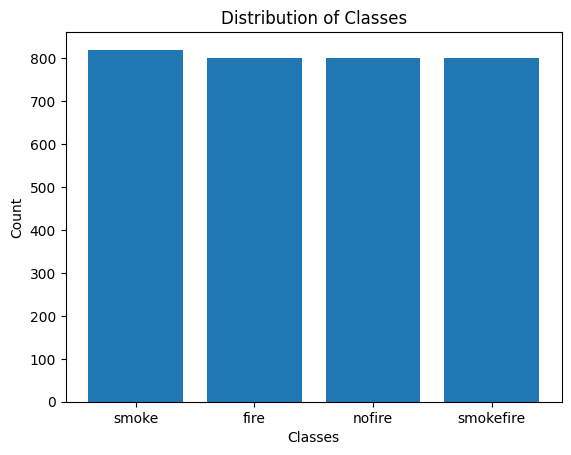

In [9]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)  # Use the folder name as the label
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create the 'train' DataFrame
train = create_dataframe(train_path)

# Now you can use 'train' in your code:
class_counts = train['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()



The goal of this is to analyze the distribution of different classes in the training dataset by counting the number od images per class and visualizing the distribution using a bar chart.

value_counts() is used to count the number of images per class.

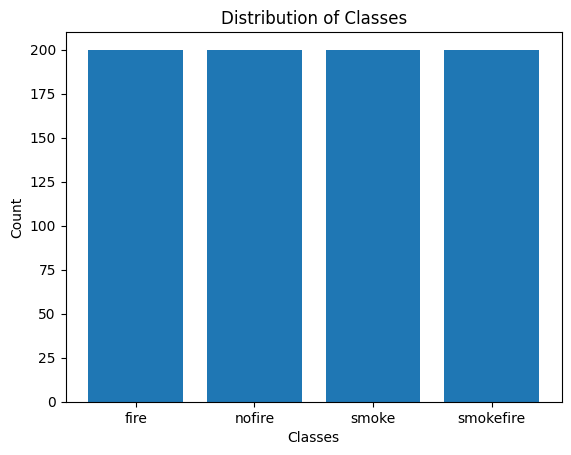

In [10]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)  # Use the folder name as the label
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create the 'test' DataFrame
test = create_dataframe(test_path)

# Now you can use 'test' in your code:
class_counts = test['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()




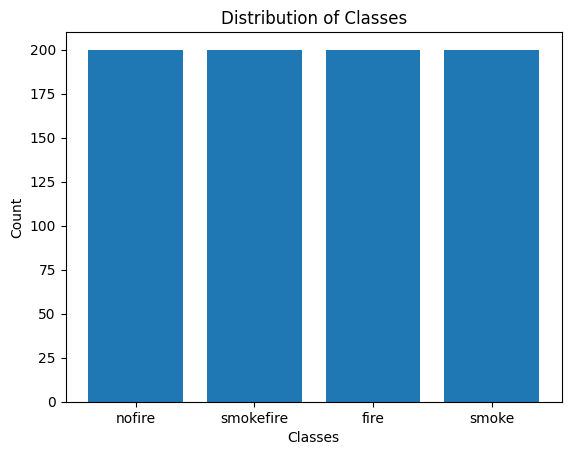

In [11]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)  # Use the folder name as the label
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create the 'test' DataFrame
val = create_dataframe(validation_path )

# Now you can use 'test' in your code:
class_counts = val['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

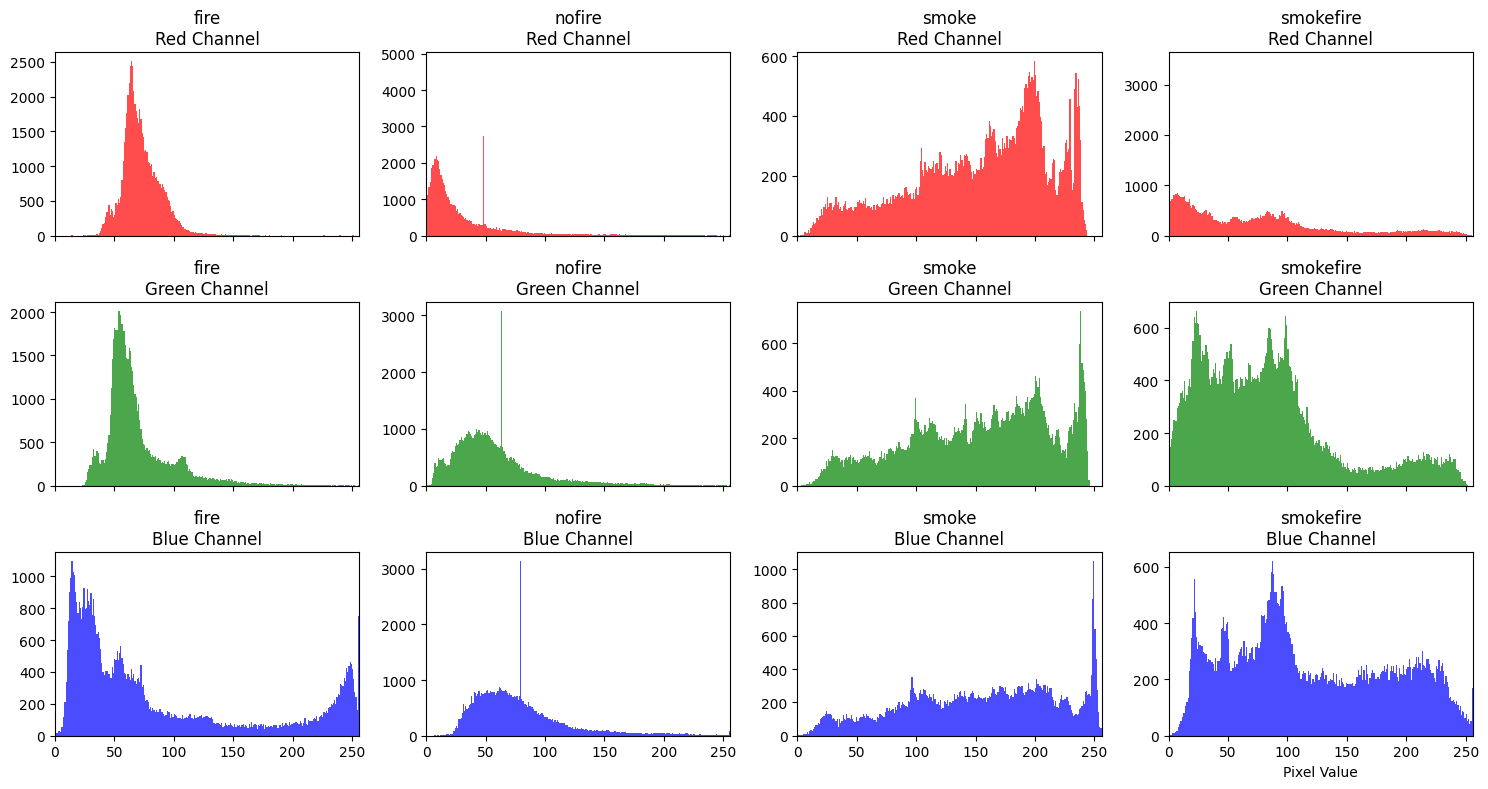

In [12]:
import cv2

# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(train)


In this we are generating histograms for the Red, Green and Blue color channels for one sample image from each class in the dataset.

* fire images have high red intensity - Red channel can be used to detect fire.
* Smoke images have higher blue and green values - these can help separate smoke from fire.
* No fire images have balanced color distributions.
* Smokefire images mix red and blue/ green could help in detecting both elements together.

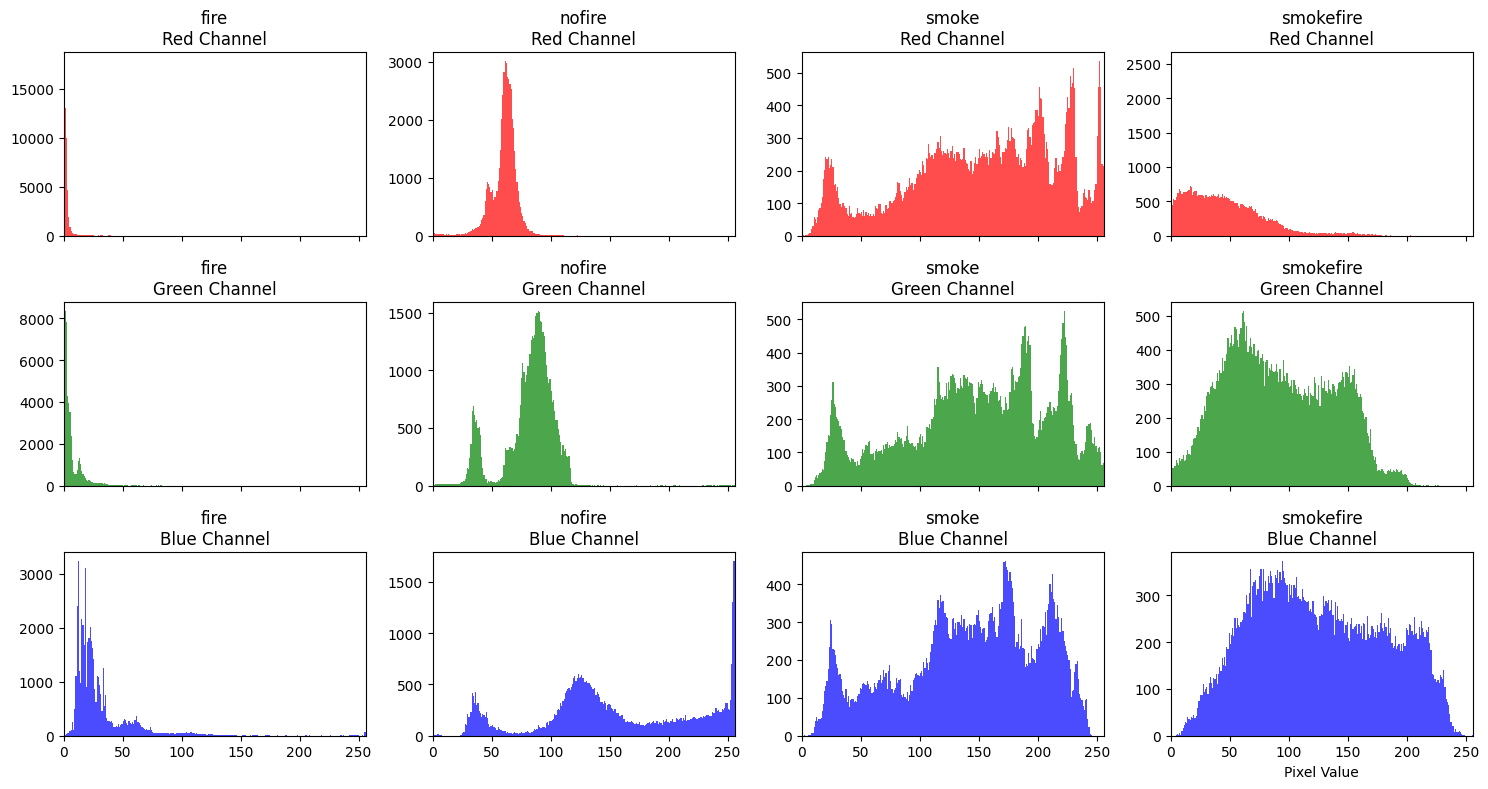

In [13]:
# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(test)


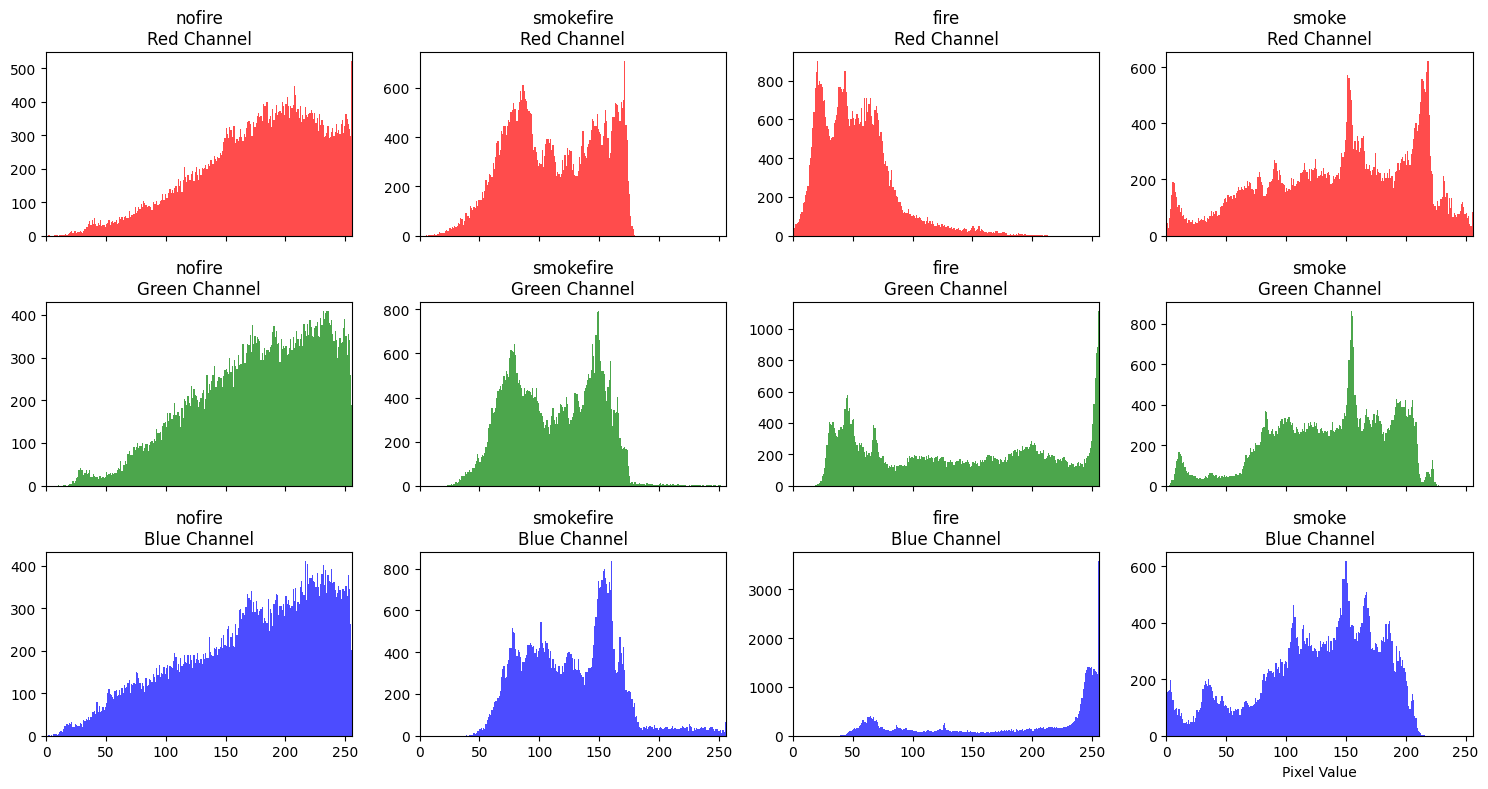

In [14]:
# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(val)


Step 4: Display Sample Images


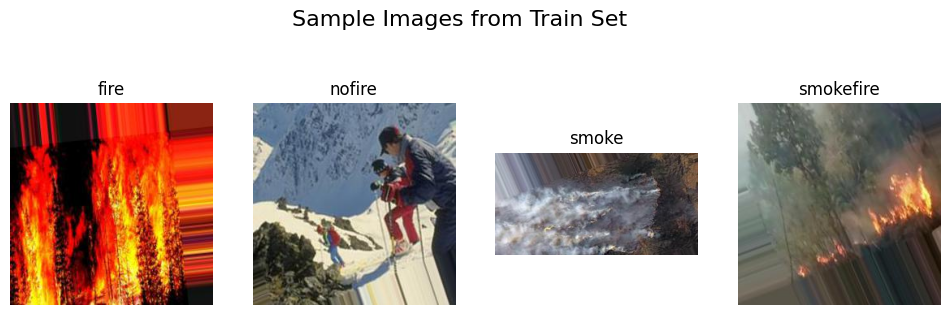

In [15]:
import matplotlib.pyplot as plt
import cv2
import random
import os

def display_images(dataset_path, title, num_cols=4):
    categories = os.listdir(dataset_path)
    categories = [c for c in categories if os.path.isdir(os.path.join(dataset_path, c))]  # Ensure only directories
    num_categories = len(categories)
    num_rows = (num_categories + num_cols - 1) // num_cols  # Calculate required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    fig.suptitle(title, fontsize=16)


    if num_rows == 1 or num_cols == 1:
        axes = axes.flatten() if isinstance(axes, np.ndarray) else axes  # Flatten only if it's a NumPy array
    else:
        axes = axes.flatten()

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        img_name = random.choice(os.listdir(category_path))  # Pick a random image
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].set_title(category)
        axes[i].axis("off")

    # Hide any unused subplot spaces
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Remove unused axes

    plt.show()

# Display images from the training set
display_images(train_path, "Sample Images from Train Set")

This is used to randomly display sample images from different categories in the dataset.

**Label Encoding**

In [16]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
train['label_code'] = label_encoder.fit_transform(train['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'fire': 0, 'nofire': 1, 'smoke': 2, 'smokefire': 3}


In this code encodes categorical labels into numberical values using label encoding.

In [17]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
test['label_code'] = label_encoder.fit_transform(test['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'fire': 0, 'nofire': 1, 'smoke': 2, 'smokefire': 3}


In [18]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
val['label_code'] = label_encoder.fit_transform(val['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)


Label Mapping:
{'fire': 0, 'nofire': 1, 'smoke': 2, 'smokefire': 3}


**Data Augmentation**


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  Data augmentation only for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#  No augmentation for validation and test sets (Only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

#  Load training images with augmentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load validation images (no augmentation)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

#  Load test images (no augmentation, no shuffling for evaluation)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3220 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.


In this train_datagen object is used to apply data agumentation to the training dataset.

* rescale=1./255 - It rescales pixel values to be between 0 and 1 by dividing each pixel value by 255. This helps normalize the image data.
* rotation_range=20 - It randomly rotates the image by up to 20 degrees.
* width_shift_range=0.2 - It randomly shifts the image horizontally by up to 20% of the total width.
* height_shift_range=0.2 - Randomly shifts the image vertically by up to 20% of the total height.
* shear_range =0.2 - It distorts by shifting the part of the image.
* zoom_range=0.2 - It zooms in randomly between 80% and 120% of the original image.
* horizontal_flip=True - Flips the image horizontally with a 50% chance.
* fill_mode = 'nearest' - using the nearest pixel value it determines how to fill in pixels taht are shifted outside of the image borders.

* val_test_datagen is used for the validation and test data. Unlike the training data no agumentation is applied here. the only transformation performed is rescaling to normalize the pixel values between 0 and 1.

* resized all images to 224x224 pixels as this is the standard size for CNNs and VGG16 and ResNet.

* as it is a multi classification problem the class mode is set as categorical, the labels will be one hot encoded.

Displaying images after augmentation and resizing


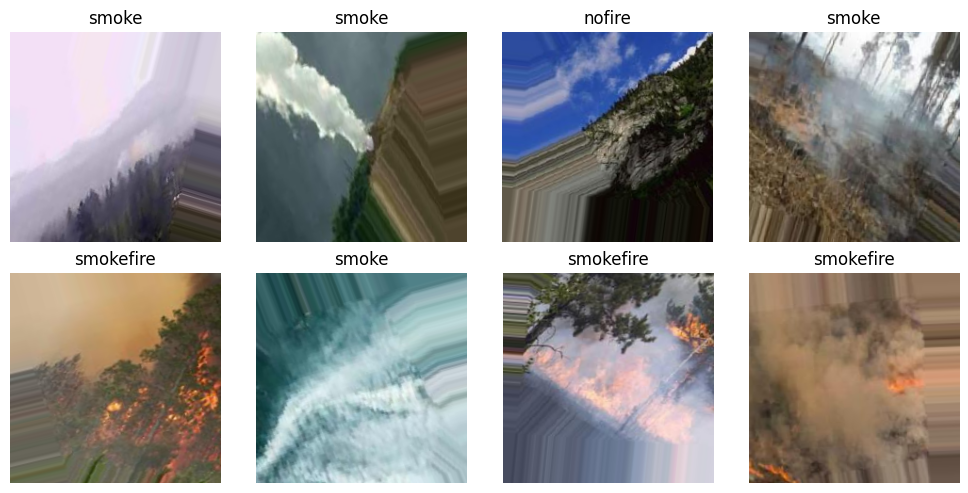

In [20]:
img_batch,label_batch=next(train_generator)
fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(10,5))
axes=axes.flatten()
for i in range(8):
  axes[i].imshow(img_batch[i])
  axes[i].axis('off')
  #axes[i].set_title(f"label:{label_batch[i]}")
  class_index=np.argmax(label_batch[i])
  class_name=train_generator.class_indices
  class_name=dict((v,k)for k,v in class_name.items())
  class_name=class_name[class_index]
  axes[i].set_title(f"{class_name}")
plt.tight_layout()
plt.show()

In this the code is designed to visualize a batch of images ( first 8 images) that are being passes through train_generator and display their corresponding class labels. It visually confirms that the images are being correctly loaded, augmented and labeled.

**Summarize Dataset Information**


In [21]:

import pandas as pd # Import the pandas library and assign it the alias 'pd'

# Create a DataFrame summarizing dataset information
data_summary = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "Total Images": [train_total, val_total, test_total],
    "Fire": [train_counts.get("fire", 0), val_counts.get("fire", 0), test_counts.get("fire", 0)],
    "No Fire": [train_counts.get("nofire", 0), val_counts.get("nofire", 0), test_counts.get("nofire", 0)],
    "Smoke": [train_counts.get("smoke", 0), val_counts.get("smoke", 0), test_counts.get("smoke", 0)],
    "Fire Smoke": [train_counts.get("smokefire", 0), val_counts.get("smokefire", 0), test_counts.get("smokefire", 0)]

})

#  Use display() to show the DataFrame in Colab
display(data_summary)


,Dataset,Total Images,Fire,No Fire,Smoke,Fire Smoke
0,Train,3220,800,800,820,800
1,Validation,800,200,200,200,200
2,Test,800,200,200,200,200


All Datasets have a balanced distribution of images across the four classes . This shows that  how the data is distributed across three datasets ( training, testing and validation ).

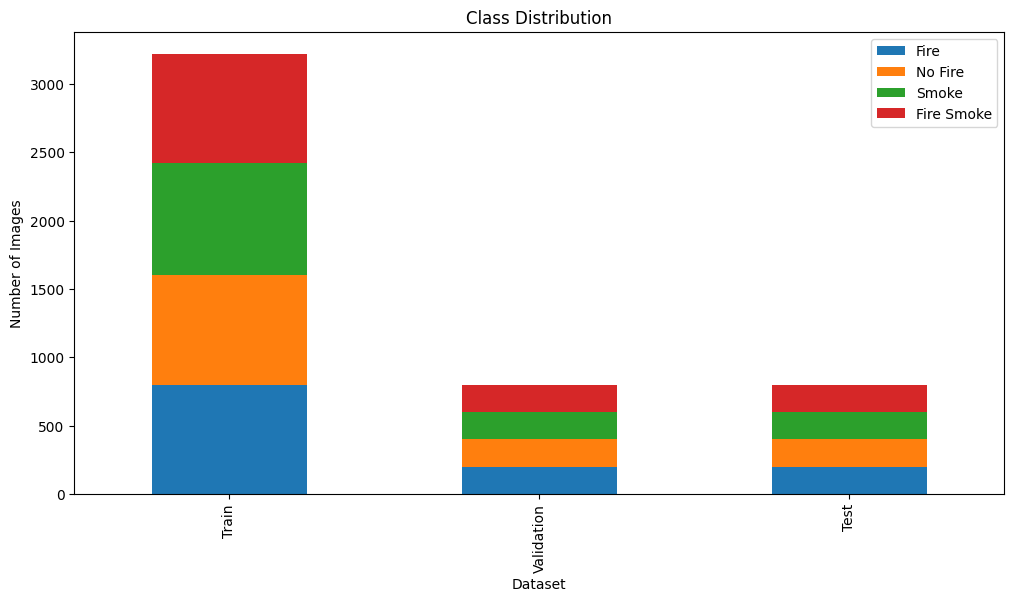

In [22]:
def plot_class_distribution(data_summary):
  data_summary.set_index("Dataset",inplace=True)
  data_summary[['Fire','No Fire',"Smoke","Fire Smoke"]].plot(kind='bar',stacked=True,figsize=(12,6))
  plt.title("Class Distribution")
  plt.xlabel("Dataset")
  plt.ylabel("Number of Images")
  plt.legend(loc='upper right')
  plt.show()

plot_class_distribution(data_summary)

**Checking if all the images have the same size or not**


In [23]:
def check_image_size(generator):
  sizes=set()
  for i in range(len(generator)):
    batch_x,batch_y=generator[i]
    for img in batch_x:
        sizes.add(img.shape[:2])
  return sizes

train_sizes=check_image_size(train_generator)
val_sizes=check_image_size(val_generator)
test_sizes=check_image_size(test_generator)
print(f"Train Image Sizes: {train_sizes}")
print(f"Validation Image Sizes: {val_sizes}")
print(f"Test Image Sizes: { test_sizes}")
if len(train_sizes)>1 or len(val_sizes)>1 or len(test_sizes)>1:
  print("All images are not having the same size")
else:
  print("All images are having the same size")

Train Image Sizes: {(224, 224)}
Validation Image Sizes: {(224, 224)}
Test Image Sizes: {(224, 224)}
All images are having the same size


All images in the dataset are having same size (224 x 224 pixels).

Since the set contains only one unique size per dataset, this confirms that all images are consistent.

**VGG16**

In [24]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
base_model.trainable=False
model=models.Sequential([base_model,
                         layers.GlobalAveragePooling2D(),
                         layers.Dense(128,activation='relu'),
                         layers.Dropout(0.5),
                         layers.Dense(4,activation='softmax')])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history=model.fit(train_generator,validation_data=val_generator,epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 99s 830ms/step - accuracy: 0.3712 - loss: 1.3264 - val_accuracy: 0.6825 - val_loss: 0.9304
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 63s 620ms/step - accuracy: 0.5888 - loss: 0.9835 - val_accuracy: 0.7563 - val_loss: 0.7490
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 93s 726ms/step - accuracy: 0.6528 - loss: 0.8518 - val_accuracy: 0.7650 - val_loss: 0.6748
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 74s 733ms/step - accuracy: 0.6742 - loss: 0.8041 - val_accuracy: 0.7975 - val_loss: 0.6169
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 584ms/step - accuracy: 0.7084 - loss: 0.7211 - val_accuracy: 0.8000 - val_loss: 0.5800
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step - accuracy: 0.7056 - loss: 0.7243 - val_accuracy: 0.8350 - val_loss: 0.5254
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 592ms/step - accuracy: 0.7405 - loss: 0.6679 - val_accuracy: 0.8100 - val_loss: 0.5567
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 80s 798ms/step - accuracy: 0.7326 - loss: 0

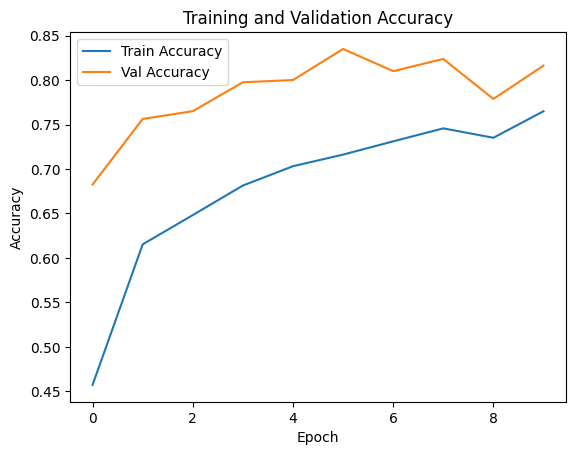

In [34]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

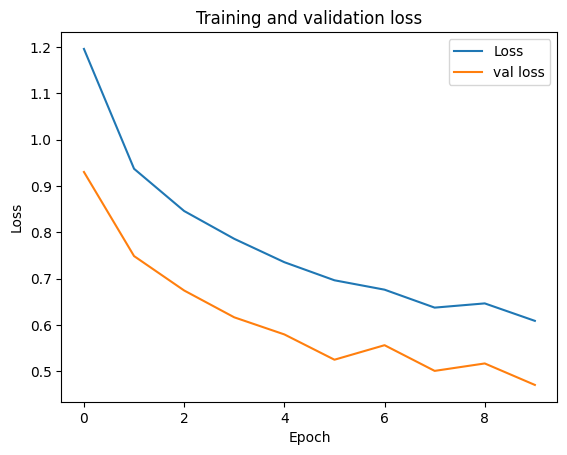

In [35]:
plt.plot(history.history["loss"],label='Loss')
plt.plot(history.history["val_loss"],label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [28]:
y_pred=model.predict(test_generator)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=test_generator.classes
class_labels=list(test_generator.class_indices.keys())
print(classification_report(y_true,y_pred_classes,target_names=class_labels))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step
              precision    recall  f1-score   support

        fire       0.97      0.46      0.62       200
      nofire       0.90      0.96      0.93       200
       smoke       0.48      0.94      0.64       200
   smokefire       0.21      0.11      0.14       200

    accuracy                           0.62       800
   macro avg       0.64      0.62      0.58       800
weighted avg       0.64      0.62      0.58       800



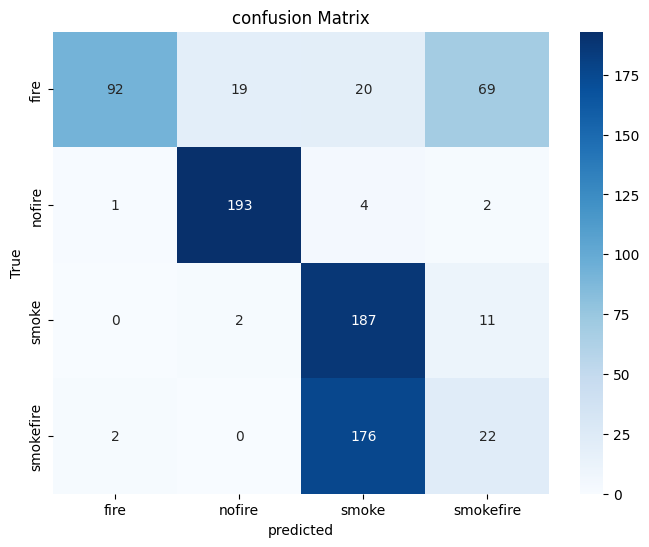

In [37]:
cm=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.xlabel("predicted")
plt.ylabel("True")
plt.title("confusion Matrix")
plt.show()

In [31]:
x_test,y_test=next(test_generator)
class_indices=test_generator.class_indices
idx_to_label=dict((v,k)for k,v in class_indices.items())


In [32]:
preds=model.predict(x_test)
pred_classes=np.argmax(preds,axis=1)
true_classes=np.argmax(y_test,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


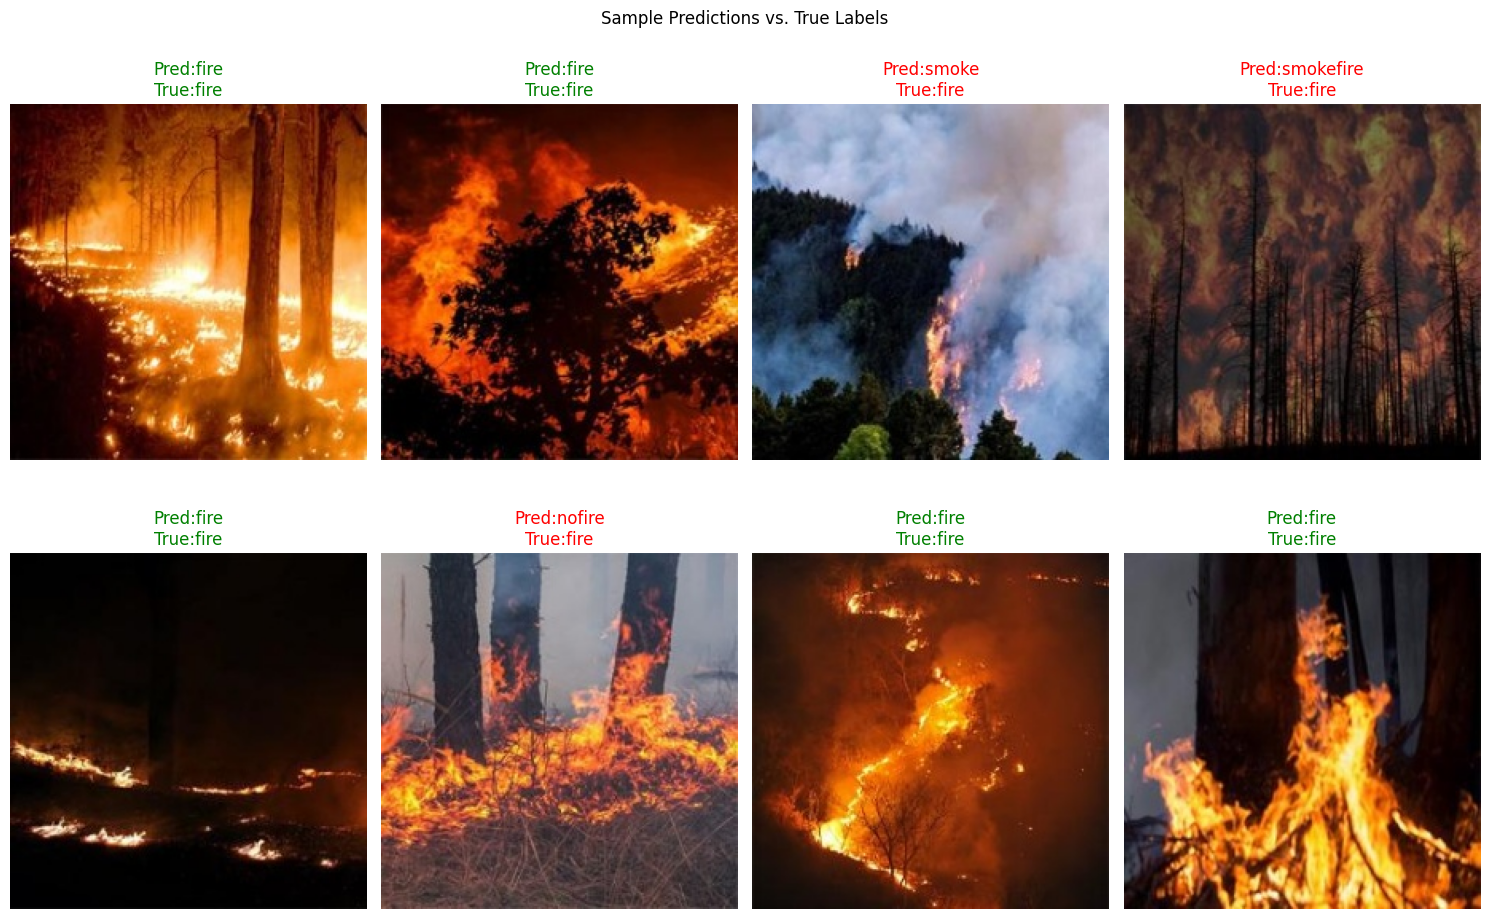

In [33]:
plt.figure(figsize=(15,10))
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(x_test[i])
  plt.axis("off")
  true_label=idx_to_label[true_classes[i]]
  pred_label=idx_to_label[pred_classes[i]]
  color="green" if true_label==pred_label else 'red'
  plt.title(f"Pred:{pred_label}\nTrue:{true_label}",color=color)
plt.suptitle("Sample Predictions vs. True Labels")
plt.tight_layout()
plt.show()

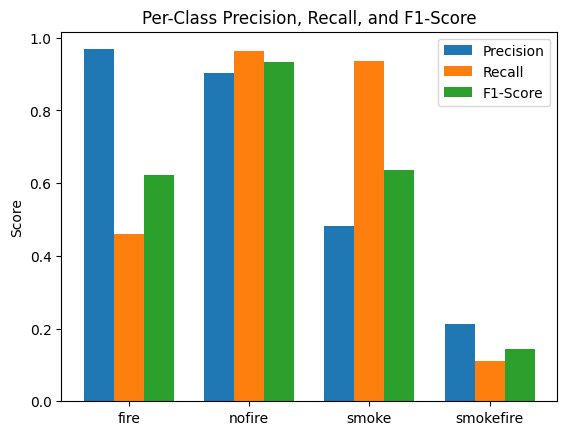

In [39]:
# Calculate class-wise metrics
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Bar chart
x = np.arange(len(class_labels))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')
plt.xticks(x, class_labels)
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall, and F1-Score')
plt.legend()
plt.show()